In [1]:
import pandas as pd
import numpy as np
import os
import codecs

In [2]:
# load datasets
business = pd.read_csv("yelp_review_business.csv")[:1000]
user = pd.read_csv("yelp_user.csv")[:1000]
review = pd.read_csv("yelp_review.csv")[:1000]

In [3]:
# select columns and pre-process 'business' dataset
business['business_avg_stars'] = business['stars']
business = business[['business_id','name','city',
                     'state','postal_code','latitude','longitude',
                     'business_avg_stars','review_count','is_open','categories']]
np.shape(business) #(156639, 12)

(1000, 11)

In [4]:
# select columns and pre-process 'user' dataset
user = user[['yelping_since','review_count','fans','average_stars','user_id']]
np.shape(user) #(1183362, 5)

(1000, 5)

In [5]:
# select columns and pre-process 'review' dataset
np.shape(review) #(4736897, 9)

(1000, 9)

In [6]:
# merge 3 datasets
data = pd.merge(review, user, how='left', on ='user_id')
data = pd.merge(data, business, how='left', on = 'business_id')
np.shape(data) #(4736897, 24)

(1000, 23)

In [7]:
# drop NAs
data = data.dropna(subset = ['stars'])

In [8]:
# add columns for NLP tags
data['stars_dif'] = data['stars'] - data['average_stars']
data['bus_stars_dif'] = data['stars'] - data['business_avg_stars']

In [9]:
# filter 51 states
data = data[data.state.isin([
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", 
    "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", 
    "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", 
    "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", 
    "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])]
np.shape(data) #(3952097, 26)

(76, 25)

In [10]:
# filter still open
data = data[data['is_open']==1]
np.shape(data) #(3505852, 26)

(65, 25)

In [11]:
# filter 'Restaurant': our targets are restaurant business owners
data = data[data['categories'].str.contains('Restaurants',na=False)]
np.shape(data) #(2043400, 26)

(46, 25)

In [12]:
# save the dataset
data.to_csv('data.csv', index=False)

In [13]:
# convert int stars column to float
data.stars = data.stars.astype(float)
data.average_stars = data.average_stars.astype(float)
[]

[]

In [14]:
data = pd.read_csv("data.csv", encoding='ISO-8859-1')
print(np.shape(data)) #(2043400, 26)
data.head()

(46, 25)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yelping_since,...,state,postal_code,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif
0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,1,0,1,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,NaN,...,PA,19403,40.141292,-75.389286,3.5,8.0,1.0,"Food, Coffee & Tea, Gas Stations, Restaurants,...",NaN,1.5
1,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5,0,0,0,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47,NaN,...,CA,93101,34.414445,-119.690672,4.0,389.0,1.0,"Food, Restaurants, Salad, Coffee & Tea, Breakf...",NaN,1.0
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,NaN,...,PA,19103,39.953291,-75.173645,4.0,65.0,1.0,"Restaurants, Delis, Salad, Sandwiches",NaN,1.0
3,jC-fGfx-YLqxVBcyTAd4Pw,EBa-0-6AKoy6jziNexDJtg,W4ZEKkva9HpAdZG88juwyQ,3,0,0,0,"In a word... ""OVERRATED!"". The food took fore...",2013-12-29 02:37:42,NaN,...,LA,70130,29.954387,-90.068363,4.0,2064.0,1.0,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",NaN,-1.0
4,4zopEEPqfwm-c_FNpeHZYw,JYYYKt6TdVA4ng9lLcXt_g,SZU9c8V2GuREDN5KgyHFJw,5,0,0,0,We were a bit weary about trying the Shellfish...,2016-05-31 02:14:54,NaN,...,CA,93101,34.408715,-119.685019,4.0,2404.0,1.0,"Live/Raw Food, Restaurants, Seafood, Beer Bar,...",NaN,1.0


In [15]:
import spacy
import nltk
import nltk.classify.util
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords, names

#nlp = spacy.load('en')
nlp = spacy.load("en_core_web_sm")

In [16]:
def textPreProcess(reviews_column):
    
    filtered = []
    temp = []
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))

    for review in reviews_column:
        words = tokenizer.tokenize(review)
        for w in words:
            if w.lower() not in stop_words:
                temp.append(w.lower())
        filtered.append(temp)
        temp = []

    return filtered

In [17]:
# get pre-processed text data
filtered = textPreProcess(data['text'])

In [18]:
def sentimentScore(data, filtered):
    
    neg_file = open("negative.txt", "r", encoding='ISO-8859-1')
    neg_dict = neg_file.read().split('\n')
    neg_file.close()

    pos_file = open("positive.txt", "r", encoding='ISO-8859-1')
    pos_dict = pos_file.read().split('\n')
    pos_file.close() 
    
    # University of Illinois at Chicago
    # https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/tree/08a269765a6b185d5f3dd522c876043ba9628715/data/opinion-lexicon-English
        
    pos_counter = 0
    neg_counter = 0
    sent_ratio = 0
    sentiment_score = []
    
    for review in filtered:
        for word in review:
            if word in pos_dict:
                pos_counter = pos_counter + 1
            if word in neg_dict:
                neg_counter = neg_counter + 1
                
        if len(review) != 0:
            sent_ratio = float(pos_counter - neg_counter) / float(len(review))  
        else:
            sent_ratio = 0
        sentiment_score.append(sent_ratio)
        pos_counter = 0
        neg_counter = 0
    
    df = pd.DataFrame(np.column_stack([filtered, sentiment_score]), columns=['filtered_text', 'sentiment_score'])
    
    # reset indexes to zero so pd.concat works properly
    data.index = (range(0, len(data)))
    df.index = (range(0, len(df)))
    return pd.concat([data, df], axis=1)

In [ ]:
scored_df = sentimentScore(data, filtered)

In [20]:
scored_df.to_csv('scored_df.csv', index=False)
print(np.shape(scored_df))
scored_df.head()

(46, 27)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yelping_since,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,1,0,1,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,NaN,...,40.141292,-75.389286,3.5,8.0,1.0,"Food, Coffee & Tea, Gas Stations, Restaurants,...",NaN,1.5,"[great, staff, always, helps, always, nice, al...",0.136364
1,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5,0,0,0,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47,NaN,...,34.414445,-119.690672,4.0,389.0,1.0,"Food, Restaurants, Salad, Coffee & Tea, Breakf...",NaN,1.0,"[great, addition, funk, zone, grab, bite, grab...",0.166667
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,NaN,...,39.953291,-75.173645,4.0,65.0,1.0,"Restaurants, Delis, Salad, Sandwiches",NaN,1.0,"[boyfriend, tried, deli, first, time, today, t...",0.083333
3,jC-fGfx-YLqxVBcyTAd4Pw,EBa-0-6AKoy6jziNexDJtg,W4ZEKkva9HpAdZG88juwyQ,3,0,0,0,"In a word... ""OVERRATED!"". The food took fore...",2013-12-29 02:37:42,NaN,...,29.954387,-90.068363,4.0,2064.0,1.0,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",NaN,-1.0,"[word, overrated, food, took, forever, come, b...",0.064516
4,4zopEEPqfwm-c_FNpeHZYw,JYYYKt6TdVA4ng9lLcXt_g,SZU9c8V2GuREDN5KgyHFJw,5,0,0,0,We were a bit weary about trying the Shellfish...,2016-05-31 02:14:54,NaN,...,34.408715,-119.685019,4.0,2404.0,1.0,"Live/Raw Food, Restaurants, Seafood, Beer Bar,...",NaN,1.0,"[bit, weary, trying, shellfish, company, wharf...",0.093567


In [21]:
# get the neg_scored dataframe for analysis
#scored_df = pd.read_csv("scored_df.csv", encoding='ISO-8859-1')
neg_scores = scored_df[scored_df['sentiment_score'] < 0]
print(np.shape(neg_scores))
neg_scores.head()

(1, 27)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yelping_since,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
42,bg3TAimbMppppLUTfN46nA,R9VOYcIWbNA3Q3qiWF2SsQ,EIlFs8kybcG-l60GJjNUIA,1,0,0,0,AVOID AT ALL COSTS\nBy far the worst pizza I'v...,2017-02-09 06:35:49,NaN,...,28.042004,-82.674612,2.5,20.0,1.0,"Pizza, Chicken Wings, Restaurants, Sandwiches",NaN,-1.5,"[avoid, costs, far, worst, pizza, thin, crust,...",-0.04878


In [25]:
# get the neg_scored dataframe for analysis
#scored_df = pd.read_csv("scored_df.csv", encoding='ISO-8859-1')
pos_scores = scored_df[scored_df['sentiment_score'] > 0]
print(np.shape(pos_scores))
pos_scores.head()

(45, 27)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,yelping_since,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
0,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,1,0,1,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24,NaN,...,40.141292,-75.389286,3.5,8.0,1.0,"Food, Coffee & Tea, Gas Stations, Restaurants,...",NaN,1.5,"[great, staff, always, helps, always, nice, al...",0.136364
1,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5,0,0,0,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47,NaN,...,34.414445,-119.690672,4.0,389.0,1.0,"Food, Restaurants, Salad, Coffee & Tea, Breakf...",NaN,1.0,"[great, addition, funk, zone, grab, bite, grab...",0.166667
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,NaN,...,39.953291,-75.173645,4.0,65.0,1.0,"Restaurants, Delis, Salad, Sandwiches",NaN,1.0,"[boyfriend, tried, deli, first, time, today, t...",0.083333
3,jC-fGfx-YLqxVBcyTAd4Pw,EBa-0-6AKoy6jziNexDJtg,W4ZEKkva9HpAdZG88juwyQ,3,0,0,0,"In a word... ""OVERRATED!"". The food took fore...",2013-12-29 02:37:42,NaN,...,29.954387,-90.068363,4.0,2064.0,1.0,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",NaN,-1.0,"[word, overrated, food, took, forever, come, b...",0.064516
4,4zopEEPqfwm-c_FNpeHZYw,JYYYKt6TdVA4ng9lLcXt_g,SZU9c8V2GuREDN5KgyHFJw,5,0,0,0,We were a bit weary about trying the Shellfish...,2016-05-31 02:14:54,NaN,...,34.408715,-119.685019,4.0,2404.0,1.0,"Live/Raw Food, Restaurants, Seafood, Beer Bar,...",NaN,1.0,"[bit, weary, trying, shellfish, company, wharf...",0.093567


In [22]:
neg_scores.to_csv('neg_scores.csv', index=False)

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\sudha\Documents\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\sudha\Documents\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [32]:
# scored_df
scored_df = pd.read_csv("scored_df.csv", encoding='ISO-8859-1')
np.shape(scored_df) #(2043401, 28)

(46, 27)

In [33]:
scored_df.describe()

,stars,useful,funny,cool,review_count_x,fans,average_stars,postal_code,latitude,longitude,business_avg_stars,review_count_y,is_open,stars_dif,bus_stars_dif,sentiment_score
count,46.000000,46.000000,46.000000,46.000000,2.000000,2.000000,2.00000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0,2.000000,46.000000,46.000000
mean,4.347826,0.826087,0.130435,0.282609,477.000000,49.500000,3.80500,56796.347826,35.311437,-95.058263,3.956522,794.891304,1.0,-0.805000,0.391304,0.136910
std,0.993700,1.767664,0.884652,0.719970,593.969696,65.760931,0.13435,30014.502644,4.549022,17.912006,0.492455,887.765741,0.0,1.548564,0.893887,0.100026
min,1.000000,0.000000,0.000000,0.000000,57.000000,3.000000,3.71000,8003.000000,27.769405,-119.882367,2.500000,8.000000,1.0,-1.900000,-1.500000,-0.048780
25%,4.000000,0.000000,0.000000,0.000000,267.000000,26.250000,3.75750,33631.750000,29.954644,-119.619867,4.000000,177.500000,1.0,-1.352500,-0.375000,0.065971
50%,5.000000,0.000000,0.000000,0.000000,477.000000,49.500000,3.80500,66561.500000,35.188256,-90.068363,4.000000,345.000000,1.0,-0.805000,0.750000,0.097170
75%,5.000000,1.000000,0.000000,0.000000,687.000000,72.750000,3.85250,89485.750000,39.896927,-82.571993,4.000000,1957.750000,1.0,-0.257500,1.000000,0.203023
max,5.000000,9.000000,6.000000,4.000000,897.000000,96.000000,3.90000,93117.000000,43.613573,-74.921519,4.500000,2404.000000,1.0,0.290000,2.000000,0.437500


In [34]:
scored_df.groupby('stars').count()

,review_id,user_id,business_id,useful,funny,cool,text,date,yelping_since,review_count_x,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
stars,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,0,1,1,1
2,2,2,2,2,2,2,2,2,1,1,...,2,2,2,2,2,2,1,2,2,2
3,5,5,5,5,5,5,5,5,0,0,...,5,5,5,5,5,5,0,5,5,5
4,10,10,10,10,10,10,10,10,1,1,...,10,10,10,10,10,10,1,10,10,10
5,28,28,28,28,28,28,28,28,0,0,...,28,28,28,28,28,28,0,28,28,28


In [35]:
print(scored_df['stars'].corr(scored_df['sentiment_score']))
print(scored_df['stars_dif'].corr(scored_df['sentiment_score']))

0.46995235495245524
1.0


In [36]:
# neg_scores
neg_scores.describe()

,stars,useful,funny,cool,review_count_x,fans,average_stars,postal_code,latitude,longitude,business_avg_stars,review_count_y,is_open,stars_dif,bus_stars_dif
count,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0,1.0,1.0,0.0,1.0
mean,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5
25%,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5
50%,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5
75%,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5
max,1.0,0.0,0.0,0.0,NaN,NaN,NaN,34677.0,28.042004,-82.674612,2.5,20.0,1.0,NaN,-1.5


In [37]:
pos_scores.groupby('stars').count()

,review_id,user_id,business_id,useful,funny,cool,text,date,yelping_since,review_count_x,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
stars,,,,,,,,,,,,,,,,,,,,,
2,2,2,2,2,2,2,2,2,1,1,...,2,2,2,2,2,2,1,2,2,2
3,5,5,5,5,5,5,5,5,0,0,...,5,5,5,5,5,5,0,5,5,5
4,10,10,10,10,10,10,10,10,1,1,...,10,10,10,10,10,10,1,10,10,10
5,28,28,28,28,28,28,28,28,0,0,...,28,28,28,28,28,28,0,28,28,28


In [38]:
import scipy as sp
print(sp.stats.spearmanr(neg_scores['stars'], neg_scores['sentiment_score']))
print(sp.stats.spearmanr(neg_scores['stars_dif'], neg_scores['sentiment_score']))

SpearmanrResult(correlation=nan, pvalue=nan)
SpearmanrResult(correlation=nan, pvalue=nan)


C:\Users\sudha\Documents\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AttributeError: module 'seaborn' has no attribute 'plt'

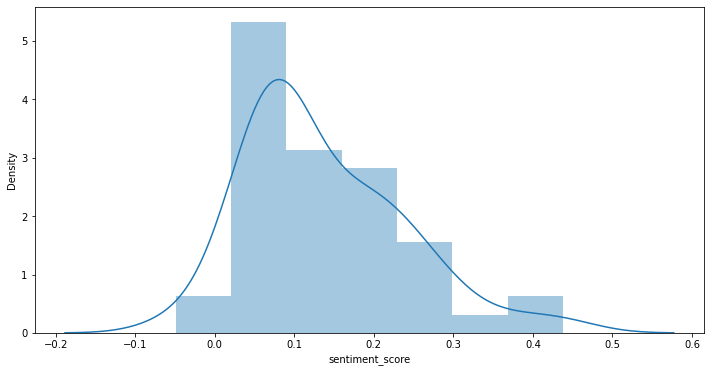

In [39]:
plt.figure(figsize=(12,6))
sns.distplot(scored_df['sentiment_score'], label='Sentiment Score')
sns.plt.xlim(-0.4,0.4)

<AxesSubplot:xlabel='stars'>

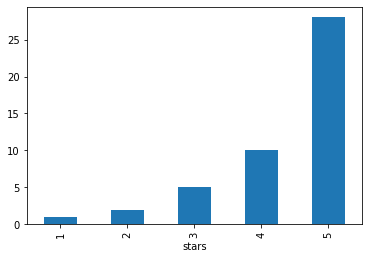

In [40]:
bar_df = scored_df.groupby('stars')['is_open'].sum()
bar_df.plot.bar()

<AxesSubplot:xlabel='stars'>

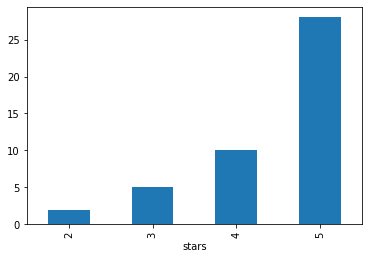

In [41]:
bar_df = pos_scores.groupby('stars')['is_open'].sum()
bar_df.plot.bar()